In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
def standard_scaler(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    norm = lambda x: (x - mean) / std
    inv_norm = lambda norm_x: norm_x * std + mean
    return norm(data), norm, inv_norm

## K Medias

### Loading Quake Data

In [4]:
quake = np.genfromtxt('./quake.csv', delimiter=',')
x,_,_ = standard_scaler(quake)
quake.shape

(2178, 2)

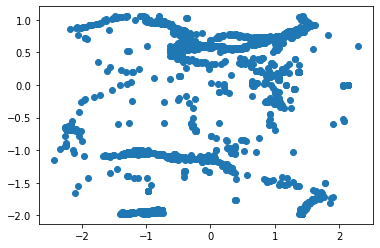

In [5]:
plt.scatter(x[:, [0]], x[:, [1]]);

### Distance Functions and DB Score

In [6]:
def euclidian_distance(x1, x2, axis=None):
    return np.linalg.norm(x1 - x2, axis=axis)

def db_index(model, x):
    cluster_distance = np.zeros((model.n_clusters, x.shape[1]))
    cluster_scatter = np.zeros((model.n_clusters, x.shape[1]))
    
    for k in range(model.n_clusters):
        cluster_scatter[k] = np.mean(model.distance_fn(x[model.labels==k], model.m[k], axis=1))

    for k in range(model.n_clusters):
        k_dists = []
        
        for j in range(model.n_clusters):
            if(j != k):
                k_dists.append(
                    (cluster_scatter[k] + cluster_scatter[j]) / model.distance_fn(model.m[k], model.m[j])
                )
        
        cluster_distance[k] = np.max(k_dists)
    
    return np.mean(cluster_distance)

### KMeans Implementation

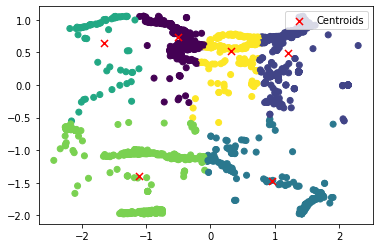

In [7]:
class KMeans():
    def __init__(self, n_clusters, distance_fn, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.distance_fn = distance_fn
        self.max_iter = max_iter
        self.random_state = random_state
        
    def distance_to_clusters(self, x, m):
        distances = np.zeros((len(x), self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = self.distance_fn(x, m[k], axis=1)
        return distances
    
    def assign_clusters(self, distances):
        return np.argmin(distances, axis=1)
    
    def update_centroids(self, x, labels):
        centroids = np.zeros((self.n_clusters, x.shape[1]))
        for k in range(self.n_clusters):
            centroids[k] = np.mean(x[labels == k], axis=0)
        return centroids
    
    def reconstrucion_error(self, x, m):
        error = 0
        for k in range(self.n_clusters):
            error += np.sum(self.distance_fn(x[self.labels==k], m[k], axis=1))
        return error
    
    def fit(self, x):
        # Initialize centroids
        rng = np.random.default_rng(self.random_state)
        self.m = rng.choice(x, size=self.n_clusters, replace=False)
        
        # Iterate until not change
        for i in range(self.max_iter):
            old_m = self.m
            
            # Calculate distances
            distances = self.distance_to_clusters(x, self.m)
            
            # Assign clusters
            self.labels = self.assign_clusters(distances)
        
            # Calculate new centroids
            self.m = self.update_centroids(x, self.labels)
            
            # Check for change
            if(np.array_equal(old_m, self.m)):
                break
    
    def get_error(self, x):
        return self.reconstrucion_error(x, self.m)
    
    def predict(self, x):
        distances = self.distance_to_clusters(x, self.m)
        return self.assign_clusters(distances)
    
    def plot_clusters(self, x):
        plt.scatter(x[:, [0]], x[:, [1]], c=self.labels)
        plt.scatter(self.m[:, [0]], self.m[:, [1]], s=50, marker='x', c='red', label='Centroids')
        plt.legend(loc='upper right');

kmeans = KMeans(6, euclidian_distance)
kmeans.fit(x)
kmeans.plot_clusters(x)

### Questão 1

In [8]:
errors = []
n_centroids = np.arange(4,21)
n_repetitions = 20

random_states = np.arange(n_repetitions)

for k in n_centroids:
    
    reconstruction_erros = []
    db_scores = []
    
    for i in range(n_repetitions):
        model = KMeans(k, euclidian_distance, random_state=random_states[i])
        model.fit(x)
        reconstruction_erros.append(model.get_error(x))
        db_scores.append(db_index(model, x))
    
    min_reconstruction_error_id = np.argmin(reconstruction_erros)
    errors.append(db_scores[min_reconstruction_error_id])

### Distância Euclidiana

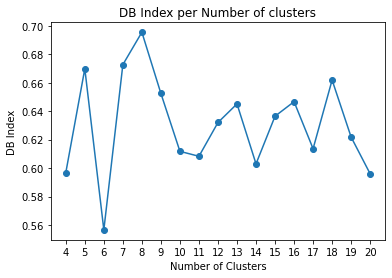

In [9]:
plt.title('DB Index per Number of clusters')
plt.plot(range(4,21), errors, '-o')
plt.xticks(range(4,21))
plt.ylabel('DB Index')
plt.xlabel('Number of Clusters');

## PCA

### Loading Peguin Data

In [10]:
penguins = np.genfromtxt('./penguins.csv', delimiter=',')
X = penguins[:, :-1]
Y = penguins[:, [-1]]

### Train Test Split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
x_train, norm_x, _ = standard_scaler(x_train)
x_test = norm_x(x_test)
y_train, _, inv_norm = standard_scaler(y_train)

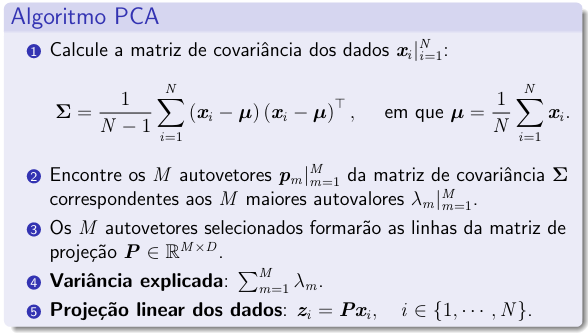

### PCA Implementation

In [12]:
class PCA():
    def __init__(self, n_components=2):
        self.n_components = n_components
    
    def fit(self, x):
        self.cov = np.cov(x, rowvar=False)
        eig_values, eig_vectors = np.linalg.eig(self.cov)
        self.tranformation_matrix = eig_vectors[:, :self.n_components]
        self.explained_varience_ = eig_values[:self.n_components]
        
    def get_covariance(self):
        return self.cov
    
    def transform(self, x):
        return x@self.tranformation_matrix

### ITEM A

In [13]:
pca = PCA(n_components=2)
pca.fit(x_train)

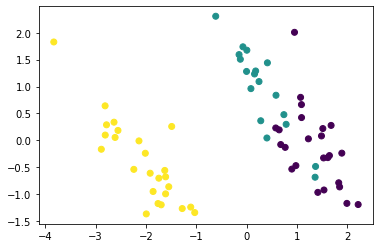

In [14]:
x_test_2d = pca.transform(x_test)
plt.scatter(x_test_2d[:, [0]], x_test_2d[:, [1]], c=y_test);

In [15]:
pca.explained_varience_

array([2.78175686, 0.75716845])

In [16]:
pca.get_covariance()

array([[ 1.00377358, -0.25844204,  0.66410069,  0.61730817],
       [-0.25844204,  1.00377358, -0.57766461, -0.4699495 ],
       [ 0.66410069, -0.57766461,  1.00377358,  0.87759599],
       [ 0.61730817, -0.4699495 ,  0.87759599,  1.00377358]])

### ITEM B

In [17]:
for n in range(1, 5):
    pca = PCA(n_components=n)
    pca.fit(x_train)
    print(f'Num. Components: {pca.n_components}, Explained Varience: {pca.explained_varience_.sum()}')

Num. Components: 1, Explained Varience: 2.781756864209255
Num. Components: 2, Explained Varience: 3.5389253188111196
Num. Components: 3, Explained Varience: 3.9047438611413225
Num. Components: 4, Explained Varience: 4.015094339622639
